# Project: Vehicle Detection and Tracking
## Goal
write a software pipeline to identify vehicles in a video from a front-facing camera on a car. The test images and project video are available in the project repository. 

---
## Imports and Useful functions

In [1]:
# import libs
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import random

In [18]:
# useful functions(from class)
# Compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    # return hist and bin edge
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# color convert
def conv_color(image, color_space='BGR'):
    freature_image=None
    # apply color conversion if other than 'RGB'
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(image)
    return feature_image

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  #lock_norm= 'L2-Hys',
                                  #transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       #lock_norm= 'L2-Hys',
                       #transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(img, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, spatial_feat=True, hist_feat=True,
                        hog_feat=True, hog_channel=0, orient=9,
                        pix_per_cell=8, cell_per_block=8):
    # Create a list to append feature vectors to
    feature_image = conv_color(img, color_space)
    features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(img.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                           orient, pix_per_cell, cell_per_block,
                                           vis=False, feature_vec=True)
        features.append(hog_features)
    return np.concatenate(features)

# draw box
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Load data

car images: 	8792, example(left):
non-car images: 	8968, example(right)


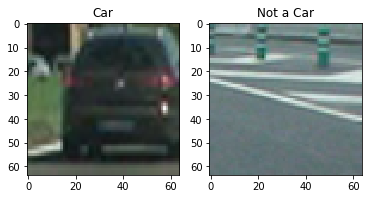

In [3]:
# prepare images / labels
# all png files. plan to use cv2.imread, color scale is 0-255
images_to_use = 4000
cars = []
notcars = []
images = glob.glob('./images/*vehicles/*/*.png')
for image in images:
    if "non" in image:
        notcars.append(image)
    else:
        cars.append(image)
print("car images: \t{}, example(left):".format(len(cars)))
print("non-car images: \t{}, example(right)".format(len(notcars)))
plt.subplot(121)
rand_car = random.randint(0, len(cars))
cur = cv2.imread(cars[rand_car])
plt.imshow(cv2.cvtColor(cur, cv2.COLOR_BGR2RGB))
plt.title("Car")
plt.subplot(122)
rand_ncar = random.randint(0, len(notcars))
cur = cv2.imread(notcars[rand_ncar])
plt.imshow(cv2.cvtColor(cur, cv2.COLOR_BGR2RGB))
plt.title("Not a Car")
plt.show()
#cars = cars[:images_to_use]
#notcars = notcars[:images_to_use]

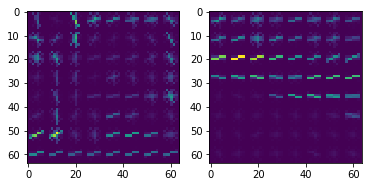

In [15]:
cur_car = cv2.imread(cars[rand_car])
car_for_hog = conv_color(cur_car, 'LUV')
ch0, img_hog = get_hog_features(car_for_hog[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)
plt.subplot(121)
plt.imshow(img_hog)
cur_ncar = cv2.imread(notcars[rand_ncar])
ncar_for_hog = conv_color(cur_ncar, 'LUV')
ch0n, img_nhog = get_hog_features(ncar_for_hog[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)
plt.subplot(122)
plt.imshow(img_nhog)
plt.show()

camera image is 1280 by 720


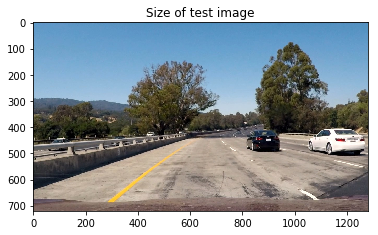

In [16]:
camera_img = mpimg.imread("test_images/test1.jpg")
print("camera image is {} by {}".format(camera_img.shape[1], camera_img.shape[0]))
plt.imshow(camera_img)
plt.title("Size of test image")
plt.show()

## Parameters

In [5]:
# Note: all images read by cv2
color_space = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

## training classfier
feature extraction and train

In [19]:
from sklearn.model_selection import train_test_split

car_features = []
for car in cars:
    car_img = cv2.imread(car) # BGR
    car_img_flip = cv2.flip(car_img, 1)
    car_feat = extract_features(car_img, color_space, spatial_size, hist_bins,
                                spatial_feat,
                                hist_feat,
                                hog_feat,
                                hog_channel,
                                orient, pix_per_cell, cell_per_block)
    car_features.append(car_feat)
    car_feat_flip = extract_features(car_img_flip, color_space, spatial_size, hist_bins,
                                spatial_feat,
                                hist_feat,
                                hog_feat,
                                hog_channel,
                                orient, pix_per_cell, cell_per_block)
    car_features.append(car_feat_flip)

ncar_features = []
for ncar in notcars:
    ncar_img = cv2.imread(ncar) # BGR
    ncar_img_flip = cv2.flip(ncar_img, 1) # BGR
    ncar_feat = extract_features(ncar_img, color_space, spatial_size, hist_bins,
                                spatial_feat,
                                hist_feat,
                                hog_feat,
                                hog_channel,
                                orient, pix_per_cell, cell_per_block)
    ncar_features.append(ncar_feat)
    ncar_feat_flip = extract_features(ncar_img_flip, color_space, spatial_size, hist_bins,
                                spatial_feat,
                                hist_feat,
                                hog_feat,
                                hog_channel,
                                orient, pix_per_cell, cell_per_block)
    ncar_features.append(ncar_feat_flip)
    
# Create an array stack of feature vectors
X = np.vstack((car_features, ncar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(ncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
# Fit a per-column scaler
print(X_train.shape)
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
# Use a linear SVC 
svc = LinearSVC(loss='hinge')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

(28416, 4932)
22.66 Seconds to train SVC...
Test Accuracy of SVC =  0.9856


## Sliding Window

In [8]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, scaler, color_space='BGR', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, color_space,
                            spatial_size, hist_bins, 
                            spatial_feat, 
                            hist_feat,
                            hog_feat, hog_channel, orient, pix_per_cell, cell_per_block)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Filter: heatmap and threshold

In [39]:
from scipy.ndimage.measurements import label
# use heatmap for multi boxes
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    labels = label(heatmap)
    return labels

def draw_labeled_bboxes(img, bbox_list, threshold=2):
    heatmap = np.zeros_like(img)
    heatmap = add_heat(heatmap, bbox_list)
    labels = apply_threshold(heatmap, threshold)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

def gen_heat(img, bbox_list, threshold=2):
    heatmap = np.zeros_like(img)
    heatmap = add_heat(heatmap, bbox_list)
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [ ]:
# persist model
import pickle
svm_model = pickle.dumps(svc)
with open("svm_model", 'wb') as f:
    pickle.dump((svc, X_scaler), f)

In [6]:
# load model
import pickle
with open("svm_model", "rb") as f:
    svc, X_scaler = pickle.load(f)

### apply HOG for each window

current colorspace: YCrCb


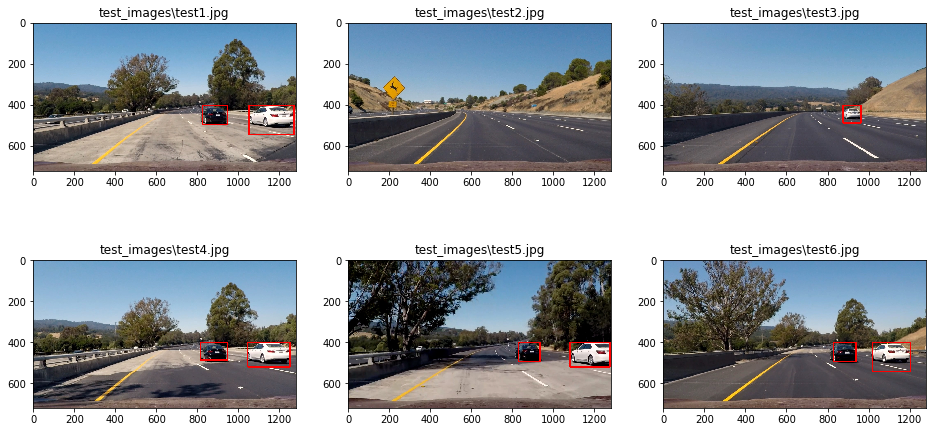

In [22]:
# apply the pipeline to example image
test_imgs = sorted(glob.glob('./test_images/*.jpg'))
# region of interest is ((0, 450), (1280, 720))
ystart = 400
ystop = 660
scale = 1
threshold = 3
# known parameters
# svc, Xscaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins
idx = 1
plt.figure(figsize=(16,8))
row = (len(test_imgs) - 1) / 3 + 1
print("current colorspace: {}".format(color_space))
image = cv2.imread(test_imgs[0])

ov = 0.8
# left side
windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[ystart, ystop], 
                    xy_window=(180, 180), xy_overlap=(ov, ov))
# right side
#windows1 += slide_window(image, x_start_stop=[1000, None], y_start_stop=[ystart, ystop], 
#                    xy_window=(128, 128), xy_overlap=(ov, ov))
# center(far)
windows1 += slide_window(image, x_start_stop=[None, None], y_start_stop=[ystart, 600], 
                    xy_window=(150, 150), xy_overlap=(ov, ov))    
windows1 += slide_window(image, x_start_stop=[None, None], y_start_stop=[ystart, 550], 
                    xy_window=(120, 120), xy_overlap=(ov, ov)) 
windows1 += slide_window(image, x_start_stop=[None, None], y_start_stop=[ystart, 500], 
                    xy_window=(80, 80), xy_overlap=(ov, ov)) 
windows1 += slide_window(image, x_start_stop=[None, None], y_start_stop=[ystart, 500], 
                    xy_window=(64, 64), xy_overlap=(ov, ov)) 
windows = windows1

image_heat = {}
for t_img in test_imgs:
    image = cv2.imread(t_img)
    image_to_plot = mpimg.imread(t_img)
    name = t_img.split("/")[-1]
    
    bbox_list = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                hist_range=(0, 256), orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
    #out_box_image.append(draw_labeled_bboxes(image, bbox_list, threshold))
    cur_img = draw_labeled_bboxes(image_to_plot, bbox_list, threshold)
    #cur_img = draw_boxes(image_to_plot, bbox_list, color=(0, 0, 255), thick=6)
    plt.subplot(row, 3, idx)
    plt.imshow(cur_img)
    plt.title("{}".format(name))
    idx += 1
    image_heat[name] = [np.zeros_like(image), bbox_list]
plt.show()

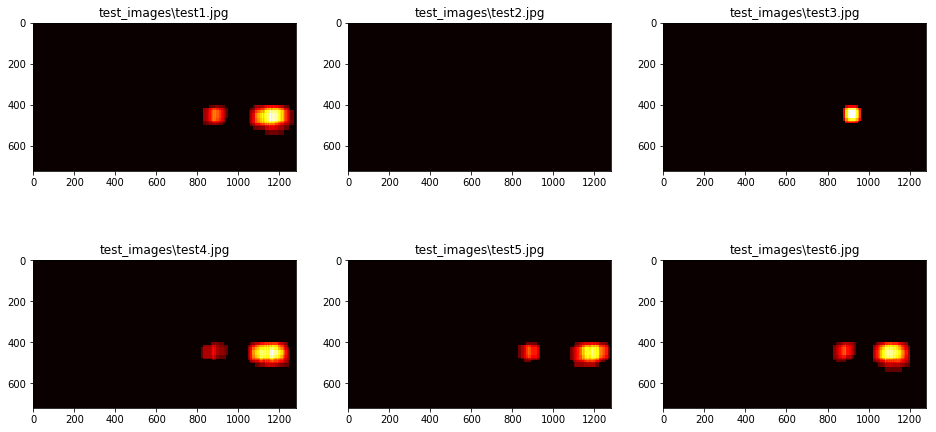

In [41]:
# plot heatmap
plt.figure(figsize=(16, 8))
idx = 1
for imgname in sorted(image_heat.keys()):
    image, bbox = image_heat[imgname]
    heats = gen_heat(image[:,:,0], bbox, threshold)
    plt.subplot(row, 3, idx)
    plt.imshow(heats, cmap="hot")
    plt.title("{}".format(imgname))
    idx += 1
plt.show()

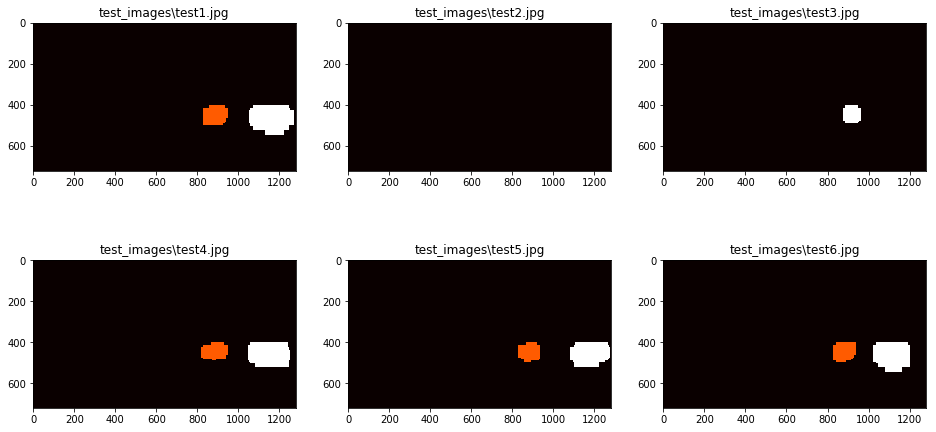

In [42]:
# plot labeled map
plt.figure(figsize=(16, 8))
idx = 1
for imgname in sorted(image_heat.keys()):
    image, bbox = image_heat[imgname]
    heats = gen_heat(image[:,:,0], bbox, threshold)
    labels = label(heats)
    plt.subplot(row, 3, idx)
    plt.imshow(labels[0], cmap="hot")
    plt.title("{}".format(imgname))
    idx += 1
plt.show()

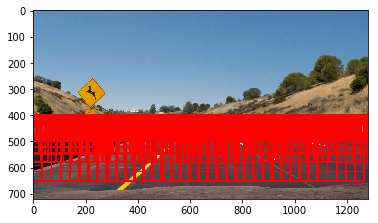

In [20]:
image_win = mpimg.imread(test_imgs[1])
small_search_windows = draw_boxes(image_win, windows, color=(0, 0, 255), thick=6)
large_search_windows = draw_boxes(small_search_windows, windows, color=(255, 0, 0), thick=6)
plt.imshow(large_search_windows)
plt.show()

## Pipeline for Video
* write pipeline to processing the video frame by frame.
* use heatmap to filter out the noise

In [11]:
# test_video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
cnt = 3
bbox_list = []
result = []
def process_image(image):
    global cnt, bbox_list, result
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if cnt == 3:
        cnt = 0
        bbox_list = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                hist_range=(0, 256), orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
    result = draw_labeled_bboxes(image, bbox_list, threshold=3)
    cnt += 1
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

In [12]:
video = './test_video.mp4'
box_output = 'test_video_boxes.mp4'
clip1 = VideoFileClip(video)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(box_output, audio=False)

[MoviePy] >>>> Building video test_video_boxes.mp4
[MoviePy] Writing video test_video_boxes.mp4


 97%|██████████████████████████████████████████████████████████████████████▏ | 38/39 [00:30<00:00,  1.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_boxes.mp4 

Wall time: 31.5 s


In [13]:
HTML("""<video width="480" height="360" controls><source src="{0}"></video>""".format(box_output))

In [43]:
# apply to full video
video = './project_video.mp4'
video_output = 'out_video.mp4'
clip2 = VideoFileClip(video)
out_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video out_video.mp4
[MoviePy] Writing video out_video.mp4


100%|███████████████████████████████████████████████████████████████████▉| 1260/1261 [17:30<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_video.mp4 

Wall time: 17min 30s


In [44]:
HTML("""<video width="480" height="360" controls><source src="{0}"></video>""".format(video_output))

In [ ]:
# test svm model on first frame
import os
def extract_frames(clip, times, imgdir):
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)

imgdir = r'C:\Downloads\Tensor\CarND-Vehicle_Detection\image_from_video'
times = (0.01, 0.02,0.03, 0.04, 0.05)

extract_frames(clip1, times, imgdir)

In [ ]:
# export video property
# fps
print("fps: {}".format(clip1.fps))

In [ ]:
video_imgs = sorted(glob.glob('./image_from_video/*.jpg'))
row = (len(video_imgs) - 1) / 3 + 1
plt.figure(figsize=(16,8))
idx = 1
for t_img in video_imgs:
    image = cv2.imread(t_img)
    image_to_plot = mpimg.imread(t_img)
    name = t_img.split("/")[-1]
    
    bbox_list = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                hist_range=(0, 256), orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
    #out_box_image.append(draw_labeled_bboxes(image, bbox_list, threshold))
    cur_img = draw_labeled_bboxes(image_to_plot, bbox_list, threshold)
    #cur_img = draw_boxes(image_to_plot, bbox_list, color=(0, 0, 255), thick=6)
    plt.subplot(row, 3, idx)
    plt.imshow(cur_img)
    plt.title("{}".format(name))
    idx += 1
plt.show()